In [2]:
import jax.numpy as jnp
import jax

from optimizers.gd import GradientDescentState, gradient_descent_step, SGDState, sgd_step


from optimizers.mrcg import MRCGState, mrcg_step

import matplotlib.pyplot as plt
from model_zoo import rosenbrock_loss, beale_loss

## Model Definition

In [3]:
initial_params = jnp.array([1.0, 2.0, 3.0])

def model(params, x):
    return x[:, 0] **2 * params[0] + x[:, 1] * params[1] + x[:, 2] * params[2]

def loss(y_pred, y_true):
    return jnp.mean((y_pred - y_true) ** 2)
x = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y_true = jnp.array([[1.0], [2.0]])

def loss_at_params(params):
    y_pred = model(params, x)
    return loss(y_pred, y_true)


In [4]:
def harder_model(params, x):
    return (
        jnp.sin(x[:, 0] * params[0]) +
        jnp.exp(-x[:, 1] * params[1]) +
        (x[:, 2] ** 2) * params[2] * jnp.sin(params[2])
    )

x = jnp.array([
        [1.0, 2.0, 3.0],
        [1.0, 5.0, -2.0],
        [0.0, 14.0, 3.0],
        [3.0, 2.0, 8.0]
        ])

## Optimizers Comparison

In [5]:
def iterate_alg(max_iters, initial_state, step_fn, verbose=False) -> list:
    losses = []
    state = initial_state
    for i in range(max_iters):
        loss = state.loss_at_params(state.params)
        losses.append(loss)

        state = step_fn(state)
        if verbose:
            print(f"Iteration {i}: Loss = {loss} Params = {state.params}")
    return losses

Iteration 0: Loss = 14379.93359375 Params = [7.56675   1.7054996]
Iteration 1: Loss = 2023.30810546875 Params = [5.6200523  0.11218679]
Iteration 2: Loss = 640.803466796875 Params = [ 4.4676557  -0.23218861]
Iteration 3: Loss = 340.7772216796875 Params = [ 3.6387534 -0.2608936]
Iteration 4: Loss = 214.75054931640625 Params = [ 2.988881   -0.21748346]
Iteration 5: Loss = 142.0692138671875 Params = [ 2.4632218  -0.16416897]
Iteration 6: Loss = 95.42294311523438 Params = [ 2.0335746  -0.11572078]
Iteration 7: Loss = 64.45588684082031 Params = [ 1.6812094  -0.07469674]
Iteration 8: Loss = 43.676544189453125 Params = [ 1.3919091  -0.04067439]
Iteration 9: Loss = 29.686542510986328 Params = [ 1.1543032  -0.01264157]
Iteration 10: Loss = 20.25835418701172 Params = [0.95913243 0.01040839]
Iteration 11: Loss = 13.903212547302246 Params = [0.7988124  0.02934868]
Iteration 12: Loss = 9.619842529296875 Params = [0.6671184  0.04490871]
Iteration 13: Loss = 6.733431816101074 Params = [0.5589387 0.05

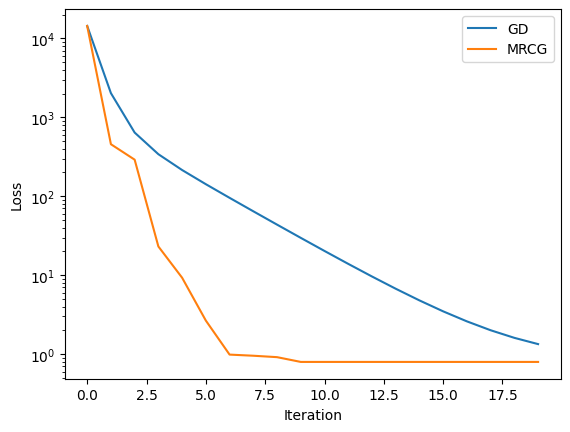

In [6]:
def plot_alg_comparison(ro, initial_params, max_iters=20):
    gd_losses = iterate_alg(
        max_iters,
        GradientDescentState(
            initial_params,
            loss_at_params,
            0.005
        ),
        gradient_descent_step,
        verbose=True
    )


    mrcg_losses = iterate_alg(
        max_iters,
        MRCGState(initial_params, loss_at_params),
        mrcg_step,
        verbose=True
    )
    plt.plot(gd_losses, label='GD')
    plt.plot(mrcg_losses, label='MRCG')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')

plot_alg_comparison(rosenbrock_loss, jnp.array([12, 8.1]), max_iters=20)

Iteration 0: Loss = 14379.93359375 Params = [7.56675   1.7054996]
Iteration 1: Loss = 2023.30810546875 Params = [5.6200523  0.11218679]
Iteration 2: Loss = 640.803466796875 Params = [ 4.4676557  -0.23218861]
Iteration 3: Loss = 340.7772216796875 Params = [ 3.6387534 -0.2608936]
Iteration 4: Loss = 214.75054931640625 Params = [ 2.988881   -0.21748346]
Iteration 5: Loss = 142.0692138671875 Params = [ 2.4632218  -0.16416897]
Iteration 6: Loss = 95.42294311523438 Params = [ 2.0335746  -0.11572078]
Iteration 7: Loss = 64.45588684082031 Params = [ 1.6812094  -0.07469674]
Iteration 8: Loss = 43.676544189453125 Params = [ 1.3919091  -0.04067439]
Iteration 9: Loss = 29.686542510986328 Params = [ 1.1543032  -0.01264157]
Iteration 10: Loss = 20.25835418701172 Params = [0.95913243 0.01040839]
Iteration 11: Loss = 13.903212547302246 Params = [0.7988124  0.02934868]
Iteration 12: Loss = 9.619842529296875 Params = [0.6671184  0.04490871]
Iteration 13: Loss = 6.733431816101074 Params = [0.5589387 0.05

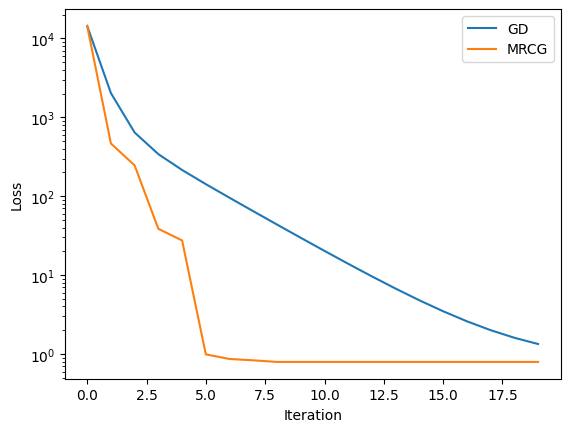

In [7]:
plot_alg_comparison(beale_loss, jnp.array([12, 8.1]), max_iters=20)

In [8]:
from jax_examples import datasets
mnist = datasets.mnist()

In [9]:
len(mnist)

4

## Stochastic

In [10]:
def make_stochastic_mse_loss(x_data: jnp.ndarray, y_data: jnp.ndarray, batch_size: int):
    """
    Returns a loss function that computes MSE on a random mini-batch.
    
    Args:
        x_data: shape (N, D)
        y_data: shape (N,)
        batch_size: int

    Returns:
        loss_fn(params, key): stochastic loss function
    """
    N = x_data.shape[0]

    def loss_fn(params: jnp.ndarray, key: jax.random.PRNGKey) -> jnp.ndarray:
        idx = jax.random.choice(key, N, shape=(batch_size,), replace=False)
        x_batch = x_data[idx]
        y_batch = y_data[idx]

        preds = x_batch @ params
        return jnp.mean((preds - y_batch) ** 2)

    return loss_fn


In [16]:
# Generate synthetic data
import jax.random as jr


key = jr.PRNGKey(0)
N, D = 1000, 10
x_data = jr.normal(key, (N, D))
true_w = jnp.arange(1, D + 1)
y_data = x_data @ true_w + 0.1 * jr.normal(key, (N,))

# Create loss function
batch_size = 32
loss_fn = make_stochastic_mse_loss(x_data, y_data, batch_size)

# Initialize parameters and SGD state
init_params = jnp.zeros(D)
sgd_state = SGDState(
    params=init_params,
    loss_at_params=loss_fn,
    step_size=1e-2,
    key=key
)
def iterate_alg_stochastic(max_iters, initial_state, step_fn, verbose=False) -> list:
    losses = []
    key = jr.PRNGKey(0)
    state = initial_state
    for i in range(max_iters):
        loss = state.loss_at_params(state.params, state.key)
        losses.append(loss)
        key, subkey = jr.split(key)
        state = step_fn(state)
        if verbose:
            print(f"Iteration {i}: Loss = {loss} Params = {state.params}")
    return losses
losses = iterate_alg_stochastic(
    20,
    sgd_state,
    sgd_step,
    verbose=True
)

Iteration 0: Loss = 618.08984375 Params = [ 0.05018305  0.1149116   0.13298473 -0.00064483  0.03115406 -0.03701438
  0.09480941  0.19909029  0.2256555   0.26673314]
Iteration 1: Loss = 320.89495849609375 Params = [ 0.18773115  0.05204345  0.28604573  0.04361424 -0.03241696  0.20225783
  0.4349635   0.33022988  0.42121077  0.49077937]
Iteration 2: Loss = 244.11727905273438 Params = [0.24488753 0.1302106  0.34328508 0.29099    0.10090984 0.23500437
 0.5185605  0.66815454 0.70756376 0.72575706]
Iteration 3: Loss = 470.0870056152344 Params = [0.18347166 0.28369886 0.42950907 0.36977202 0.19115907 0.22343764
 0.6054791  0.82835543 0.87142825 0.84763765]
Iteration 4: Loss = 564.1064453125 Params = [0.2235865  0.33225584 0.52482164 0.5339371  0.28151232 0.27361375
 0.65329576 1.0393268  0.9716756  1.0818897 ]
Iteration 5: Loss = 307.1757507324219 Params = [0.15350294 0.45653492 0.70294285 0.6377331  0.5089654  0.39992985
 0.7756288  1.3142918  1.1725045  1.3312358 ]
Iteration 6: Loss = 262.63

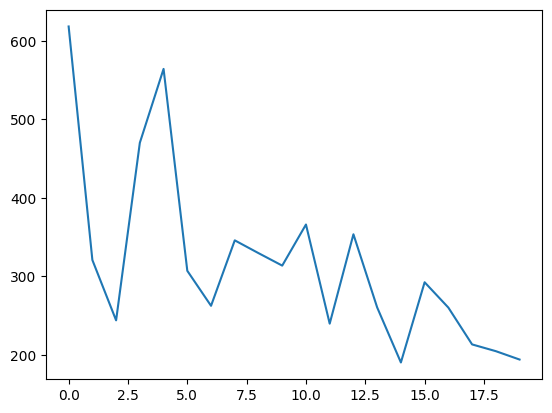

In [17]:
plt.plot(losses)